## Finetuning with SimCLRv2

##### Copyright 2020 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/simclr/blob/master/colabs/finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [2]:
# Import required libraries
import re
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# Label the classes with class ids

# Code snippet credit: https://github.com/google-research/big_transfer

!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt

imgnt_int_to_str = {}

with open('ilsvrc2012_wordnet_lemmas.txt', 'r') as f:
  for ii in range(1000):
    r = f.readline()
    row = r.rstrip()
    imgnt_int_to_str.update({ii: row})

df_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog','frog','horse','ship','truck']

--2020-09-27 04:42:23--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 74.125.202.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt.4’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2020-09-27 04:42:23 (63.8 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt.4’ saved [21675/21675]



In [4]:
# Utility functions:

#Preprocessing functions from data_util.py in SimCLR repository.

FLAGS_color_jitter_strength = 0.3
CROP_PROPORTION = 0.875  # Standard for ImageNet.


def random_apply(func, p, x):
  """Random application of the function func to x with probability p."""
  return tf.cond(
      tf.less(tf.random_uniform([], minval=0, maxval=1, dtype=tf.float32),
              tf.cast(p, tf.float32)),
      lambda: func(x),
      lambda: x)


def random_brightness(image, max_delta, impl='simclrv2'):
  """A multiplicative as opposed to additive change of brightness."""
  if impl == 'simclrv2':
    factor = tf.random_uniform(
        [], tf.maximum(1.0 - max_delta, 0), 1.0 + max_delta)
    image = image * factor
  elif impl == 'simclrv1':
    image = random_brightness(image, max_delta=max_delta)
  else:
    raise ValueError('Unknown impl {} for random brightness.'.format(impl))
  return image


def to_grayscale(image, keep_channels=True):
  image = tf.image.rgb_to_grayscale(image)
  if keep_channels:
    image = tf.tile(image, [1, 1, 3])
  return image


def color_jitter(image,
                 strength,
                 random_order=True):
  brightness = 0.8 * strength
  contrast = 0.8 * strength
  saturation = 0.8 * strength
  hue = 0.2 * strength
  if random_order:
    return color_jitter_rand(image, brightness, contrast, saturation, hue)
  else:
    return color_jitter_nonrand(image, brightness, contrast, saturation, hue)


def color_jitter_nonrand(image, brightness=0, contrast=0, saturation=0, hue=0):
  with tf.name_scope('distort_color'):
    def apply_transform(i, x, brightness, contrast, saturation, hue):
      if brightness != 0 and i == 0:
        x = random_brightness(x, max_delta=brightness)
      elif contrast != 0 and i == 1:
        x = tf.image.random_contrast(
            x, lower=1-contrast, upper=1+contrast)
      elif saturation != 0 and i == 2:
        x = tf.image.random_saturation(
            x, lower=1-saturation, upper=1+saturation)
      elif hue != 0:
        x = tf.image.random_hue(x, max_delta=hue)
      return x

    for i in range(4):
      image = apply_transform(i, image, brightness, contrast, saturation, hue)
      image = tf.clip_by_value(image, 0., 1.)
    return image


def color_jitter_rand(image, brightness=0, contrast=0, saturation=0, hue=0):
  with tf.name_scope('distort_color'):
    def apply_transform(i, x):
      def brightness_foo():
        if brightness == 0:
          return x
        else:
          return random_brightness(x, max_delta=brightness)
      def contrast_foo():
        if contrast == 0:
          return x
        else:
          return tf.image.random_contrast(x, lower=1-contrast, upper=1+contrast)
      def saturation_foo():
        if saturation == 0:
          return x
        else:
          return tf.image.random_saturation(
              x, lower=1-saturation, upper=1+saturation)
      def hue_foo():
        if hue == 0:
          return x
        else:
          return tf.image.random_hue(x, max_delta=hue)
      x = tf.cond(tf.less(i, 2),
                  lambda: tf.cond(tf.less(i, 1), brightness_foo, contrast_foo),
                  lambda: tf.cond(tf.less(i, 3), saturation_foo, hue_foo))
      return x

    perm = tf.random_shuffle(tf.range(4))
    for i in range(4):
      image = apply_transform(perm[i], image)
      image = tf.clip_by_value(image, 0., 1.)
    return image


def _compute_crop_shape(
    image_height, image_width, aspect_ratio, crop_proportion):
  image_width_float = tf.cast(image_width, tf.float32)
  image_height_float = tf.cast(image_height, tf.float32)

  def _requested_aspect_ratio_wider_than_image():
    crop_height = tf.cast(tf.rint(
        crop_proportion / aspect_ratio * image_width_float), tf.int32)
    crop_width = tf.cast(tf.rint(
        crop_proportion * image_width_float), tf.int32)
    return crop_height, crop_width

  def _image_wider_than_requested_aspect_ratio():
    crop_height = tf.cast(
        tf.rint(crop_proportion * image_height_float), tf.int32)
    crop_width = tf.cast(tf.rint(
        crop_proportion * aspect_ratio *
        image_height_float), tf.int32)
    return crop_height, crop_width

  return tf.cond(
      aspect_ratio > image_width_float / image_height_float,
      _requested_aspect_ratio_wider_than_image,
      _image_wider_than_requested_aspect_ratio)


def center_crop(image, height, width, crop_proportion):
  shape = tf.shape(image)
  image_height = shape[0]
  image_width = shape[1]
  crop_height, crop_width = _compute_crop_shape(
      image_height, image_width, height / width, crop_proportion)
  offset_height = ((image_height - crop_height) + 1) // 2
  offset_width = ((image_width - crop_width) + 1) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_height, offset_width, crop_height, crop_width)

  image = tf.image.resize_bicubic([image], [height, width])[0]

  return image


def distorted_bounding_box_crop(image,
                                bbox,
                                min_object_covered=0.1,
                                aspect_ratio_range=(0.75, 1.33),
                                area_range=(0.05, 1.0),
                                max_attempts=100,
                                scope=None):

  with tf.name_scope(scope, 'distorted_bounding_box_crop', [image, bbox]):
    shape = tf.shape(image)
    sample_distorted_bounding_box = tf.image.sample_distorted_bounding_box(
        shape,
        bounding_boxes=bbox,
        min_object_covered=min_object_covered,
        aspect_ratio_range=aspect_ratio_range,
        area_range=area_range,
        max_attempts=max_attempts,
        use_image_if_no_bounding_boxes=True)
    bbox_begin, bbox_size, _ = sample_distorted_bounding_box

    # Crop the image to the specified bounding box.
    offset_y, offset_x, _ = tf.unstack(bbox_begin)
    target_height, target_width, _ = tf.unstack(bbox_size)
    image = tf.image.crop_to_bounding_box(
        image, offset_y, offset_x, target_height, target_width)

    return image


def crop_and_resize(image, height, width):
  bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
  aspect_ratio = width / height
  image = distorted_bounding_box_crop(
      image,
      bbox,
      min_object_covered=0.1,
      aspect_ratio_range=(3. / 4 * aspect_ratio, 4. / 3. * aspect_ratio),
      area_range=(0.08, 1.0),
      max_attempts=100,
      scope=None)
  return tf.image.resize_bicubic([image], [height, width])[0]


def gaussian_blur(image, kernel_size, sigma, padding='SAME'):
  radius = tf.to_int32(kernel_size / 2)
  kernel_size = radius * 2 + 1
  x = tf.to_float(tf.range(-radius, radius + 1))
  blur_filter = tf.exp(
      -tf.pow(x, 2.0) / (2.0 * tf.pow(tf.to_float(sigma), 2.0)))
  blur_filter /= tf.reduce_sum(blur_filter)
  # One vertical and one horizontal filter.
  blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
  blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
  num_channels = tf.shape(image)[-1]
  blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
  blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
  expand_batch_dim = image.shape.ndims == 3
  if expand_batch_dim:
    # Tensorflow requires batched input to convolutions, which we can fake with
    # an extra dimension.
    image = tf.expand_dims(image, axis=0)
  blurred = tf.nn.depthwise_conv2d(
      image, blur_h, strides=[1, 1, 1, 1], padding=padding)
  blurred = tf.nn.depthwise_conv2d(
      blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
  if expand_batch_dim:
    blurred = tf.squeeze(blurred, axis=0)
  return blurred


def random_crop_with_resize(image, height, width, p=1.0):
  def _transform(image):  # pylint: disable=missing-docstring
    image = crop_and_resize(image, height, width)
    return image
  return random_apply(_transform, p=p, x=image)


def random_color_jitter(image, p=1.0):
  def _transform(image):
    color_jitter_t = functools.partial(
        color_jitter, strength=FLAGS_color_jitter_strength)
    image = random_apply(color_jitter_t, p=0.8, x=image)
    return random_apply(to_grayscale, p=0.2, x=image)
  return random_apply(_transform, p=p, x=image)


def random_blur(image, height, width, p=1.0):
  del width
  def _transform(image):
    sigma = tf.random.uniform([], 0.1, 2.0, dtype=tf.float32)
    return gaussian_blur(
        image, kernel_size=height//10, sigma=sigma, padding='SAME')
  return random_apply(_transform, p=p, x=image)


def batch_random_blur(images_list, height, width, blur_probability=0.5):
  def generate_selector(p, bsz):
    shape = [bsz, 1, 1, 1]
    selector = tf.cast(
        tf.less(tf.random_uniform(shape, 0, 1, dtype=tf.float32), p),
        tf.float32)
    return selector

  new_images_list = []
  for images in images_list:
    images_new = random_blur(images, height, width, p=1.)
    selector = generate_selector(blur_probability, tf.shape(images)[0])
    images = images_new * selector + images * (1 - selector)
    images = tf.clip_by_value(images, 0., 1.)
    new_images_list.append(images)

  return new_images_list


def preprocess_for_train(image, height, width,
                         color_distort=True, crop=True, flip=True):
  if crop:
    image = random_crop_with_resize(image, height, width)
  if flip:
    image = tf.image.random_flip_left_right(image)
  if color_distort:
    image = random_color_jitter(image)
  image = tf.reshape(image, [height, width, 3])
  image = tf.clip_by_value(image, 0., 1.)
  return image


def preprocess_for_eval(image, height, width, crop=True):
  if crop:
    image = center_crop(image, height, width, crop_proportion=CROP_PROPORTION)
  image = tf.reshape(image, [height, width, 3])
  image = tf.clip_by_value(image, 0., 1.)
  return image


def preprocess_image(image, height, width, is_training=False,
                     color_distort=True, test_crop=True):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  if is_training:
    return preprocess_for_train(image, height, width, color_distort)
  else:
    return preprocess_for_eval(image, height, width, test_crop)

In [5]:
# Utility function
# LARS optimizer from data_util.py in SimCLR repository.

EETA_DEFAULT = 0.001

class LARSOptimizer(tf.train.Optimizer):
  """Layer-wise Adaptive Rate Scaling for large batch training.

  Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
  I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
  """

  def __init__(self,
               learning_rate,
               momentum=0.9,
               use_nesterov=False,
               weight_decay=0.0,
               exclude_from_weight_decay=None,
               exclude_from_layer_adaptation=None,
               classic_momentum=True,
               eeta=EETA_DEFAULT,
               name="LARSOptimizer"):
    """Constructs a LARSOptimizer.

    Args:
      learning_rate: A `float` for learning rate.
      momentum: A `float` for momentum.
      use_nesterov: A 'Boolean' for whether to use nesterov momentum.
      weight_decay: A `float` for weight decay.
      exclude_from_weight_decay: A list of `string` for variable screening, if
          any of the string appears in a variable's name, the variable will be
          excluded for computing weight decay. For example, one could specify
          the list like ['batch_normalization', 'bias'] to exclude BN and bias
          from weight decay.
      exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
          for layer adaptation. If it is None, it will be defaulted the same as
          exclude_from_weight_decay.
      classic_momentum: A `boolean` for whether to use classic (or popular)
          momentum. The learning rate is applied during momeuntum update in
          classic momentum, but after momentum for popular momentum.
      eeta: A `float` for scaling of learning rate when computing trust ratio.
      name: The name for the scope.
    """
    super(LARSOptimizer, self).__init__(False, name)

    self.learning_rate = learning_rate
    self.momentum = momentum
    self.weight_decay = weight_decay
    self.use_nesterov = use_nesterov
    self.classic_momentum = classic_momentum
    self.eeta = eeta
    self.exclude_from_weight_decay = exclude_from_weight_decay
    # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
    # arg is None.
    if exclude_from_layer_adaptation:
      self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
    else:
      self.exclude_from_layer_adaptation = exclude_from_weight_decay

  def apply_gradients(self, grads_and_vars, global_step=None, name=None):
    if global_step is None:
      global_step = tf.train.get_or_create_global_step()
    new_global_step = global_step + 1

    assignments = []
    for (grad, param) in grads_and_vars:
      if grad is None or param is None:
        continue

      param_name = param.op.name

      v = tf.get_variable(
          name=param_name + "/Momentum",
          shape=param.shape.as_list(),
          dtype=tf.float32,
          trainable=False,
          initializer=tf.zeros_initializer())

      if self._use_weight_decay(param_name):
        grad += self.weight_decay * param

      if self.classic_momentum:
        trust_ratio = 1.0
        if self._do_layer_adaptation(param_name):
          w_norm = tf.norm(param, ord=2)
          g_norm = tf.norm(grad, ord=2)
          trust_ratio = tf.where(
              tf.greater(w_norm, 0), tf.where(
                  tf.greater(g_norm, 0), (self.eeta * w_norm / g_norm),
                  1.0),
              1.0)
        scaled_lr = self.learning_rate * trust_ratio

        next_v = tf.multiply(self.momentum, v) + scaled_lr * grad
        if self.use_nesterov:
          update = tf.multiply(self.momentum, next_v) + scaled_lr * grad
        else:
          update = next_v
        next_param = param - update
      else:
        next_v = tf.multiply(self.momentum, v) + grad
        if self.use_nesterov:
          update = tf.multiply(self.momentum, next_v) + grad
        else:
          update = next_v

        trust_ratio = 1.0
        if self._do_layer_adaptation(param_name):
          w_norm = tf.norm(param, ord=2)
          v_norm = tf.norm(update, ord=2)
          trust_ratio = tf.where(
              tf.greater(w_norm, 0), tf.where(
                  tf.greater(v_norm, 0), (self.eeta * w_norm / v_norm),
                  1.0),
              1.0)
        scaled_lr = trust_ratio * self.learning_rate
        next_param = param - scaled_lr * update

      assignments.extend(
          [param.assign(next_param),
           v.assign(next_v),
           global_step.assign(new_global_step)])
    return tf.group(*assignments, name=name)

  def _use_weight_decay(self, param_name):
    """Whether to use L2 weight decay for `param_name`."""
    if not self.weight_decay:
      return False
    if self.exclude_from_weight_decay:
      for r in self.exclude_from_weight_decay:
        if re.search(r, param_name) is not None:
          return False
    return True

  def _do_layer_adaptation(self, param_name):
    """Whether to do layer-wise learning rate adaptation for `param_name`."""
    if self.exclude_from_layer_adaptation:
      for r in self.exclude_from_layer_adaptation:
        if re.search(r, param_name) is not None:
          return False
    return True

In [6]:
# Load tensorflow datasets (cifar10)

batch = 64
ds_name = 'cifar10'

tfds_dataset, tfds_info = tfds.load(
    ds_name, split='train', with_info=True)
num_images = tfds_info.splits['train'].num_examples
num_classes = tfds_info.features['label'].num_classes

def _preprocess(x):
  x['image'] = preprocess_image(
      x['image'], 224, 224, is_training=False, color_distort=False)
  return x
x = tfds_dataset.map(_preprocess).batch(batch)
x = tf.data.make_one_shot_iterator(x).get_next()

In [7]:
# Construct the computation graph

lr = 0.1
momentum = 0.9
weight_decay = 0.0

# set the base network to on trainable
tfhub_path = 'gs://simclr-checkpoints/simclrv2/finetuned_100pct/r50_1x_sk0/hub/'
module = hub.Module(tfhub_path, trainable=False)
key = module(inputs=x['image'], signature="default", as_dict=True)

# Attach a trainable linear layer
with tf.variable_scope('head_supervised_new', reuse=tf.AUTO_REUSE):
  logit_t = tf.layers.dense(inputs=key['final_avg_pool'], units=num_classes)
loss_t = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    labels=tf.one_hot(x['label'], num_classes), logits=logit_t))

# Setup an optimizer
optimizer = LARSOptimizer(
    lr,
    momentum=momentum,
    weight_decay=weight_decay,
    exclude_from_weight_decay=['batch_normalization', 'bias', 'head_supervised'])
train_variables = tf.trainable_variables() 
train_op = optimizer.minimize(
    loss_t, global_step=tf.train.get_or_create_global_step(),
    var_list=train_variables)

print('Variables to train: {}'.format(train_variables))
key 

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Variables to train: [<tf.Variable 'head_supervised_new/dense/kernel:0' shape=(2048, 10) dtype=float32>, <tf.Variable 'head_supervised_new/dense/bias:0' shape=(10,) dtype=float32>]


{'block_group1': <tf.Tensor 'module_apply_default/base_model/block_group1:0' shape=(None, 56, 56, 256) dtype=float32>,
 'block_group2': <tf.Tensor 'module_apply_default/base_model/block_group2:0' shape=(None, 28, 28, 512) dtype=float32>,
 'block_group3': <tf.Tensor 'module_apply_default/base_model/block_group3:0' shape=(None, 14, 14, 1024) dtype=float32>,
 'block_group4': <tf.Tensor 'module_apply_default/base_model/block_group4:0' shape=(None, 7, 7, 2048) dtype=float32>,
 'default': <tf.Tensor 'module_apply_default/base_model/final_avg_pool:0' shape=(None, 2048) dtype=float32>,
 'final_avg_pool': <tf.Tensor 'module_apply_default/base_model/final_avg_pool:0' shape=(None, 2048) dtype=float32>,
 'initial_conv': <tf.Tensor 'module_apply_default/base_model/initial_conv:0' shape=(None, 112, 112, 64) dtype=float32>,
 'initial_max_pool': <tf.Tensor 'module_apply_default/base_model/initial_max_pool:0' shape=(None, 56, 56, 64) dtype=float32>,
 'logits_sup': <tf.Tensor 'module_apply_default/head_

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [9]:
# Finetune the new linear layer

num_iterations = 5

for it in range(num_iterations):
  _, loss, image, logits, labels = sess.run((train_op, loss_t, x['image'], logit_t, x['label']))
  pred = logits.argmax(-1)
  correct = np.sum(pred == labels)
  total = labels.size
  print("[Iteration: {}] Loss: {} Top 1: {}".format(it+1, loss, correct/float(total)))

[Iteration: 1] Loss: 2.593461751937866 Top 1: 0.109375
[Iteration: 2] Loss: 3.4092280864715576 Top 1: 0.203125
[Iteration: 3] Loss: 4.441411018371582 Top 1: 0.140625
[Iteration: 4] Loss: 5.735182285308838 Top 1: 0.34375
[Iteration: 5] Loss: 5.507526397705078 Top 1: 0.46875


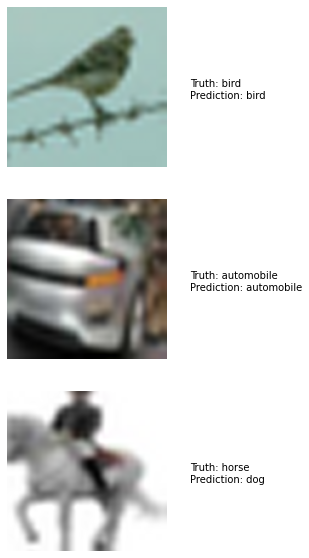

In [10]:
# Make prediction and visualize images
img, axes = plt.subplots(3, 1, figsize=(10, 10))
for j in range(3):
  axes[j].imshow(image[j])
  true_text = df_labels[labels[j]]
  pred_text = df_labels[pred[j]]
  axes[j].axis('off')
  axes[j].text(256, 128, 'Truth: ' + true_text + '\n' + 'Prediction: ' + pred_text)

Supervised Classification with Resnet50 (Finetuning without SimCLR)

In [31]:
# Import required libraries

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator


In [40]:
# Load the data
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [24]:
path_resnet_weights = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [25]:
path_resnet_weights

'../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [27]:
# Train model
model = Sequential()
model.add(ResNet50(include_top = False, pooling ='avg', weights = None))
model.add(Dense(10, activation = 'softmax'))
model.layers[0].trainable = False

In [28]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [30]:
# Optimize and compile

grad_sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = grad_sgd, loss ='categorical_crossentropy', metrics = ['accuracy'])

In [41]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3)
checkpoint = ModelCheckpoint(filepath = '../working/cifar10_chkp.hdf5',
                                  monitor = 'val_loss',
                                  save_best_only = True,
                                  mode = 'auto')

In [ ]:
fit_history = model.fit(
        x_train, y_train,
        steps_per_epoch= 10,
        epochs = 3,
        validation_data= (x_test, y_test),
        validation_steps=10,
        callbacks=[checkpoint, early_stopping]
)
model.load_weights("../working/cifar10_chkp.hdf5")

Train on 10 samples, validate on 10000 samples
Epoch 1/3
10/10 [==============================] - ETA: 0s - batch: 4.5000 - size: 1.0000 - loss: 9.6957 - accuracy: 0.1045  WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


10/10 [==============================] - 2482s 248s/step - batch: 4.5000 - size: 1.0000 - loss: 9.6957 - accuracy: 0.1045 - val_loss: 13.9573 - val_accuracy: 0.1000
Epoch 2/3
 8/10 [=======================>......] - ETA: 7:14 - batch: 3.5000 - size: 1.0000 - loss: 9.2355 - accuracy: 0.1225 

In [ ]:
# Get the history details
print(fit_history.history.keys())